In [1]:
import os
import string
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# 1.1 Check transects

A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

In [2]:
# Set inputs
fp = 'datasets' #File path
fn_tran =  'transects_coords.csv' #File name for transects
target_trans = ['Transect2', 'Transect5', 'Transect8'] # Target transects for evaluation
shoreline_orientation = 35 # Shorelkine orientation (degrees)

# Read data
df_tran = pd.read_csv(os.path.join(fp, fn_tran), index_col='ID')
df_tran

,Land_x,Land_y,Sea_x,Sea_y
ID,,,,
Transect1,463.810852,880.924590,748.408892,599.888166
Transect2,383.756554,792.082469,694.641549,540.433331
Transect3,316.183743,699.231069,644.833124,471.282315
Transect4,257.524125,610.852678,593.043798,393.113504
Transect5,204.799094,527.785536,538.509074,307.356214
Transect6,146.184639,442.402003,483.870858,227.919454
Transect7,87.900983,342.714416,441.075510,155.000819
Transect8,36.335441,234.596687,406.417477,82.993029
Transect9,0.000000,129.837061,378.240760,0.000000


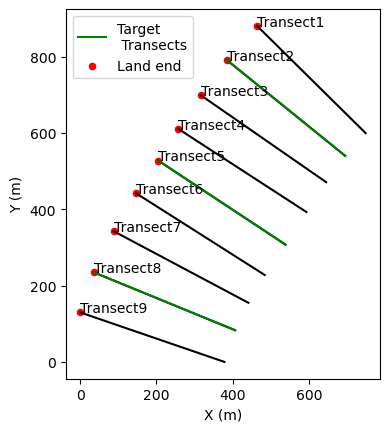

In [3]:
# Visualize transects
fig, ax = plt.subplots(1,1)

# Plot transects
ax.plot(df_tran[['Land_x', 'Sea_x']].transpose(), 
        df_tran[['Land_y', 'Sea_y']].transpose(),
        color='k')

# Plot target transects
ax.plot(df_tran.loc[target_trans, ['Land_x', 'Sea_x']].transpose(), 
        df_tran.loc[target_trans, ['Land_y', 'Sea_y']].transpose(),
        color='g')
ax.plot([], [], color='g', label='Target\n Transects')

# Highlight landward ends
df_tran.plot.scatter('Land_x', 'Land_y', c='r', 
                     label='Land end', ax=ax)


# Add transect labels
for i, row in df_tran.iterrows():
    ax.text(row['Land_x'], row['Land_y'], i)

# Set ax labels
ax.set_aspect('equal')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.legend()
plt.savefig('figures/transects.jpg', dpi=300, bbox_inches='tight')

# 1.2 Check shoreline positions

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

In [4]:
fn_obs =  'shorelines_obs.csv' # File name for shoreline observation
fn_targ_short =  'shorelines_hidden_short.csv' # File name for short-term shoreline prediction target
fn_targ_medium =  'shorelines_hidden_medium.csv' # File name for medium-term shoreline prediction target
fn_gt =  'shorelines_groundtruth.csv' #File name for groudtruth

# Read shoreline data
df_gt = pd.read_csv(os.path.join(fp, 'shorelines', fn_gt), index_col='Datetime')
df_gt.index = pd.to_datetime(df_gt.index)

df_targ_short = pd.read_csv(os.path.join(fp, 'shorelines', fn_targ_short), index_col='Datetime')
df_targ_short.index = pd.to_datetime(df_targ_short.index)

df_targ_medium = pd.read_csv(os.path.join(fp, 'shorelines', fn_targ_medium), index_col='Datetime')
df_targ_medium.index = pd.to_datetime(df_targ_medium.index)

df_obs = pd.read_csv(os.path.join(fp, 'shorelines', fn_obs), index_col='Datetime')
df_obs.index = pd.to_datetime(df_obs.index)
df_obs

,Transect1,Transect2,Transect3,Transect4,Transect5,Transect6,Transect7,Transect8,Transect9
Datetime,,,,,,,,,
1999-02-17,197.025794,192.969658,194.385116,196.570713,203.401153,207.902414,206.323159,199.502146,193.688521
1999-03-05,185.473336,186.279262,184.123460,181.000405,206.612193,198.473587,205.950591,195.028865,180.209910
1999-06-25,203.434419,198.020000,190.394388,187.103369,174.737676,175.541281,171.384529,167.083654,181.939221
1999-07-11,199.726943,203.252659,196.139268,183.378867,187.835172,183.248025,179.708851,170.776831,184.349005
1999-07-19,198.314195,192.192448,194.484527,188.295508,184.851746,181.916500,181.849139,166.181496,175.351397
...,...,...,...,...,...,...,...,...,...
2018-09-17,213.394475,208.873642,207.614407,200.922483,189.609754,197.508301,186.292343,175.528700,NaN
2018-10-19,NaN,205.638208,204.622951,195.457303,201.689672,196.422823,190.711102,184.904075,NaN
2018-11-04,204.162356,198.982894,192.175758,202.318754,199.186722,191.612484,190.450079,181.909032,185.167295


## 1.2.1 Spatial variation

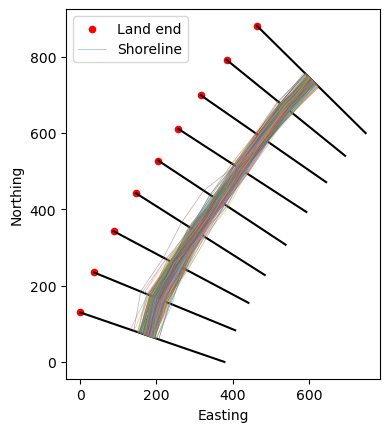

In [5]:
# Spatial view of shoreline position
land_x, land_y = df_tran['Land_x'], df_tran['Land_y'] # Land end coords
sea_x, sea_y = df_tran['Sea_x'], df_tran['Sea_y'] # Sea end coords
tran_len = np.sqrt((sea_x-land_x)**2+(sea_y-land_y)**2) # Length of transect


fig, ax = plt.subplots(1,1)

# Plot transects
ax.plot(df_tran[['Land_x', 'Sea_x']].transpose(), 
        df_tran[['Land_y', 'Sea_y']].transpose(),
        color='k')

# Plot land ends
df_tran.plot.scatter('Land_x', 'Land_y', c='r', 
                     label='Land end', ax=ax)

# Iterate dates
for date, row_obs in df_obs.iterrows():
    
    # Only label first shoreline
    if date == df_obs.index[0]:
        label_obs = 'Shoreline'
    else:
        label_obs = None
    
    # Calculate shoreline coords
    x_obs = land_x + row_obs/tran_len*(sea_x-land_x)
    y_obs = land_y + row_obs/tran_len*(sea_y-land_y)
    
    # Plot shoreline
    ax.plot(x_obs, y_obs, alpha=0.5, linewidth=0.5, label=label_obs)
        
    
    
ax.set_aspect('equal')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

ax.legend()
plt.savefig('figures/shorelines_spatial.jpg', dpi=300, bbox_inches='tight')

### 1.2.2 Temporal variation

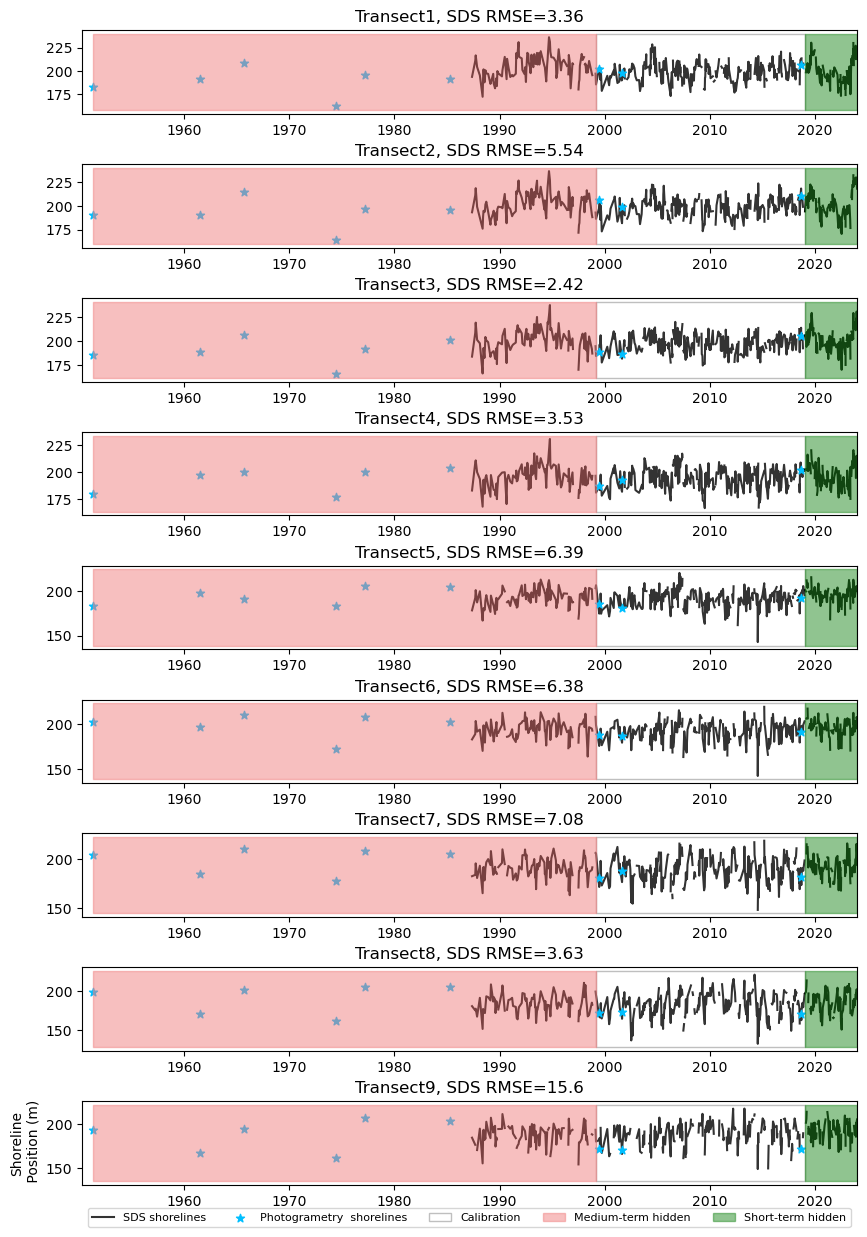

In [6]:
# Temporal view of shoreline position
df_diff = df_obs.resample('D').interpolate('linear').reindex(df_gt.index) - df_gt
RMSE = np.sqrt((df_diff**2).mean())
sep_time = datetime.datetime(year=1986, month=1, day=1)

fig, axes = plt.subplots(len(df_tran), 1, figsize=(10, 15))

# Iterate transects 
for i, tran_id in enumerate(df_tran.index):
    
    #ax = axes[int(i%(len(df_tran)/2)), int(i//(len(df_tran)/2))]
    ax = axes[i]

    
    # Plot time series of shoreline
    ax.plot(df_obs.index, df_obs[tran_id], color='k', label='SDS shorelines', zorder=-1, alpha=0.8)
    ax.scatter(df_gt.index, df_gt[tran_id], color='deepskyblue', marker='*', 
               label='Photogrametry  shorelines', zorder=1)
    ax.plot(df_targ_medium[df_targ_medium.index>=sep_time].index, df_targ_medium[df_targ_medium.index>=sep_time][tran_id], 
            color='k', zorder=1)
    ax.scatter(df_targ_medium[df_targ_medium.index<sep_time].index, df_targ_medium[df_targ_medium.index<sep_time][tran_id], 
        color='deepskyblue', marker='*')
    ax.plot(df_targ_short.index, df_targ_short[tran_id], color='k', zorder=1)
    
    ylim_up, ylim_down = ax.get_ylim()
    ax.fill_between(df_obs.index, ylim_up, ylim_down, alpha=0.5,
            color='white', edgecolor='grey', label='Calibration', zorder=-100)
    ax.fill_between([df_targ_medium.index[0], df_obs.index[0]], ylim_up, ylim_down, alpha=0.5, 
                    color='lightcoral', label='Medium-term hidden')
    ax.fill_between(df_targ_short.index, ylim_up, ylim_down, alpha=0.5, 
                    color='forestgreen', label='Short-term hidden')

    
    ax.set_title('{}, SDS RMSE={:.3}'.format(tran_id, RMSE[tran_id]))
    ax.set_xlim((df_targ_medium.index.min()-pd.Timedelta(days=365), df_targ_short.index.max()))
    
    if i == 8:
        ax.set_ylabel('Shoreline\n Position (m)')
        ax.legend(ncol=5, fontsize=8, loc=2, bbox_to_anchor=[0,-0.21])
        
fig.subplots_adjust(hspace=0.6)
plt.savefig('figures/shorelines_temporal.jpg', dpi=300, bbox_inches='tight')

### 1.2.3 Spatio-temporal analysis

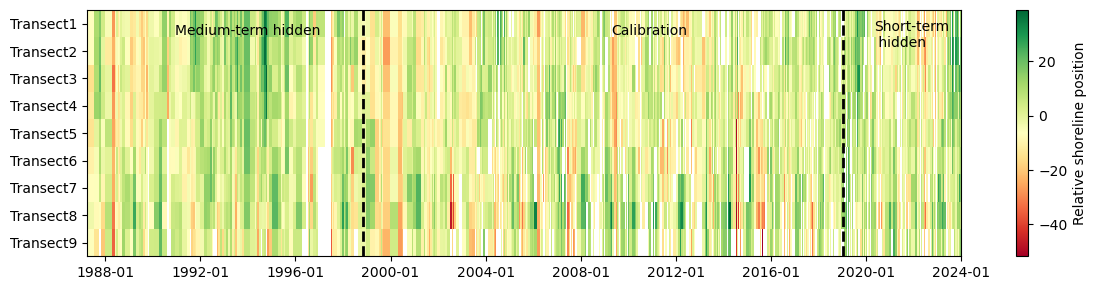

In [13]:
df_SDS = pd.concat([df_targ_medium[df_targ_medium.index>=sep_time], df_obs, df_targ_short])
df_SDS_rel = (df_SDS - df_SDS.median(0))
x = mdates.date2num(df_SDS_rel.index)  # Convert datetime to float for pcolormesh
y = np.arange(len(df_SDS_rel.columns))[::-1]  # This will be your transect indices

# Create the meshgrid for plotting
X, Y = np.meshgrid(x, y)
Z = df_SDS_rel.T.values  # Shape should be (n_transects, n_dates)

# Set up the plot with pcolormesh
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
hmap = ax.pcolormesh(X, Y, Z, shading='auto', cmap='RdYlGn')

# Draw vertical lines and add text labels
ax.axvline(df_targ_medium.index[-1], 0, 1, color='k', linestyle='--', linewidth=2)
ax.axvline(df_targ_short.index[0], 0, 1, color='k', linestyle='--', linewidth=2)
ax.text(0.1, 0.9, 'Medium-term hidden', transform=ax.transAxes)
ax.text(0.6, 0.9, 'Calibration', transform=ax.transAxes)
ax.text(0.9, 0.85, 'Short-term\n hidden', transform=ax.transAxes)

# Set the color bar
plt.colorbar(hmap, label='Relative shoreline position')

# Configure x-axis for datetime
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set y-ticks to show transect labels in reverse
ax.set_yticks(ticks=y, labels=df_SDS_rel.columns)  # Reverse the labels to match the y-axis

# Set labels
# plt.xlabel('Year')
# plt.ylabel('Transects')

# Show and save the plot
plt.tight_layout()
plt.savefig('figures/shorelines_spatio_temporal.jpg', dpi=300, bbox_inches='tight')

### 1.2.4 EOF analysis

In [14]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

df_SDS_resample = df_SDS.resample('1MS').mean().interpolate()

# Step 1: Demean the dataset (remove the mean from each time series)
df_demeaned = df_SDS_resample - df_SDS_resample.mean(axis=0)

# Step 2: Perform Singular Value Decomposition (SVD) using PCA (which internally uses SVD)
pca = PCA(n_components=min(df_demeaned.shape))  # Number of components limited by the smaller dimension

# Fit the PCA model to the demeaned data
pca.fit(df_demeaned)

# Step 3: Extract EOFs (spatial patterns, e_k) and Principal Components (temporal patterns, c_k)
EOFs = pca.components_  # These are the e_k (spatial EOFs), shape: (num_components, num_locations)
PCs = pca.transform(df_demeaned)  # These are the c_k (temporal components), shape: (num_timepoints, num_components)

# Step 4: Variance explained by each EOF
explained_variance = pca.explained_variance_ratio_

cross_shore_modes = 0 # Cross-shore component
long_shore_modes = 1 # Longshore component
cross_shore_reconstruction = np.dot(PCs[:, [cross_shore_modes]], EOFs[[cross_shore_modes], :])
long_shore_reconstruction = np.dot(PCs[:, [long_shore_modes]], EOFs[[long_shore_modes], :])

cs_df = pd.DataFrame(cross_shore_reconstruction, index=df_SDS_resample.index, columns=df_SDS_resample.columns)
ls_df = pd.DataFrame(long_shore_reconstruction, index=df_SDS_resample.index, columns=df_SDS_resample.columns)

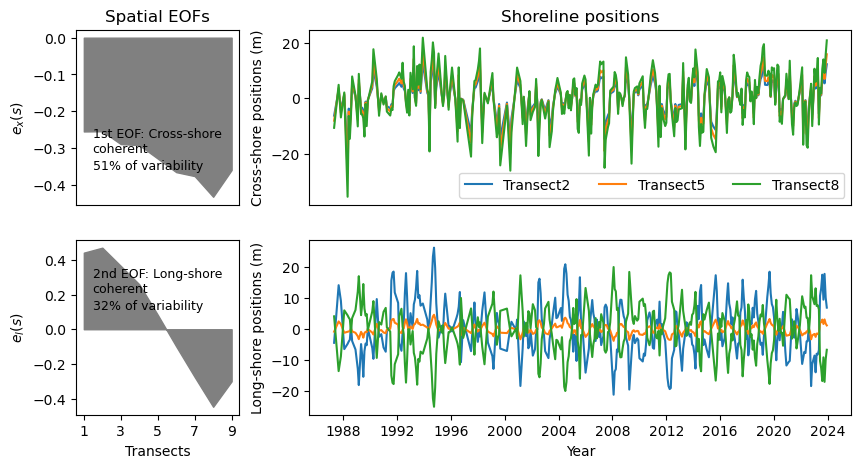

In [15]:
# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.2, 4]})
alongshore_coord = range(1, len(df_SDS_resample.columns)+1)

# Plot 1st EOF (Cross-Shore Coherent)
axs[0, 0].fill_between(alongshore_coord, EOFs[cross_shore_modes], color='grey')
axs[0, 0].set_title('Spatial EOFs')
axs[0, 0].set_ylabel(r'$e_{x}(s)$')
#axs[0, 0].set_xlabel('Transects')
axs[0, 0].text(0.1, 0.3, '1st EOF: Cross-shore\ncoherent', fontsize=9, transform=axs[0,0].transAxes)
axs[0, 0].text(0.1, 0.2, '{:.0%} of variability'.format(explained_variance[cross_shore_modes]), 
               fontsize=9, transform=axs[0,0].transAxes)
axs[0, 0].set_xticks([])

# Plot 1st PC (Temporal EOF for Cross-Shore)
for tran in target_trans:
    axs[0, 1].plot(cs_df.index, cs_df[tran], label=tran)
axs[0, 1].legend(ncol=3)
axs[0, 1].set_title('Shoreline positions')
axs[0, 1].set_ylabel('Cross-shore positions (m)')
axs[0, 1].set_xticks([])
#axs[0, 1].set_xlabel('Year')

# # Plot 2nd EOF (Long-Shore Coherent)
axs[1, 0].fill_between(alongshore_coord, EOFs[long_shore_modes], color='gray')
axs[1, 0].set_ylabel(r'$e_{l}(s)$')
axs[1, 0].set_xlabel('Alongshore coordinate, s (m)')
axs[1, 0].set_xlabel('Transects')
axs[1, 0].text(0.1, 0.7, '2nd EOF: Long-shore\ncoherent', fontsize=9, transform=axs[1,0].transAxes)
axs[1, 0].text(0.1, 0.6, '{:.0%} of variability'.format(explained_variance[long_shore_modes]), 
               fontsize=9, transform=axs[1,0].transAxes)
axs[1, 0].set_xticks([1, 3, 5, 7, 9])

# Plot 2nd PC (Temporal EOF for Long-Shore)
for tran in target_trans:
    axs[1, 1].plot(ls_df.index, ls_df[tran], label=tran)
axs[1, 1].set_ylabel('Long-shore positions (m)')
axs[1, 1].set_xlabel('Year')

# plt.tight_layout()
# plt.show()
plt.savefig('figures/EOF_analysis.jpg', dpi=300, bbox_inches='tight')

# 1.3 Check Waves

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [16]:
# Read data

# Hs: Significant wave height
# Tp: Peak wave period
# Dir: Mean wave direction

WAVE_PARAMS = ['Hs', 'Tp', 'Dir'] 

dfs_wave = {}
for wave_param in WAVE_PARAMS:
    df_wave = pd.read_csv(
        os.path.join(fp, 'hindcast_waves' ,'{}.csv'.format(wave_param)),
        index_col = 'Datetime'
    )
    df_wave.index = pd.to_datetime(df_wave.index)
    dfs_wave[wave_param] = df_wave
    


# 1.3.1 Check wave roses for different transects

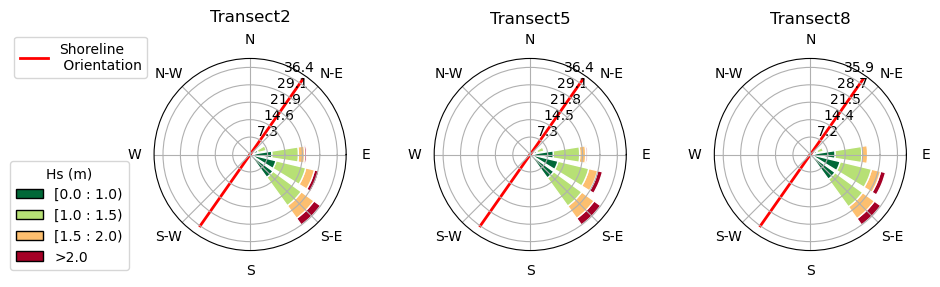

In [17]:
# Plot wave roses

fig, axes = plt.subplots(ncols=3, figsize=(10, 3),
                        subplot_kw={'projection': 'windrose'})

for i, tran_id in enumerate(target_trans):
    ax = axes[i]
    
    # Plot wave rose for Hs
    ax.bar(dfs_wave['Dir'][tran_id], dfs_wave['Hs'][tran_id], normed=True, opening=0.8, bins=[0, 1, 1.5, 2], 
        cmap=cm.RdYlGn_r, edgecolor='white')
    ax.set_title(tran_id)
    
    theta = np.deg2rad(90-shoreline_orientation)
    opposite_theta = np.deg2rad(270-shoreline_orientation)  # opposite angle
    ax.plot([opposite_theta, opposite_theta], [0, ax.get_rmax()], color='red', linewidth=2, label='Shoreline Orientation', zorder=-100)
    ax.plot([theta, theta], [0, ax.get_rmax()], color='red', linewidth=2, label='Shoreline Orientation', zorder=-100)

    if i == 0:
        ax.legend()
        cbar = ax.legend(loc=(-0.75, -0.1), title='Hs (m)')

        ax2 = ax.inset_axes([0, 1, 0.15, 0.15])
        shoreline_legend = ax2.plot([], [], color='red', linewidth=2, label='Shoreline\n Orientation')
        ax2.legend(bbox_to_anchor=[0,1], loc=1, ncol=1)
        ax2.axis('off')
        
plt.tight_layout()
plt.savefig('figures/wave_roses.jpg', dpi=300, bbox_inches='tight')

# 1.3.2 Check time series of wave parameters (Average across transects)

Hs:1.1793068665671653
Tp:9.110097406700913
Dir:114.06228404017459


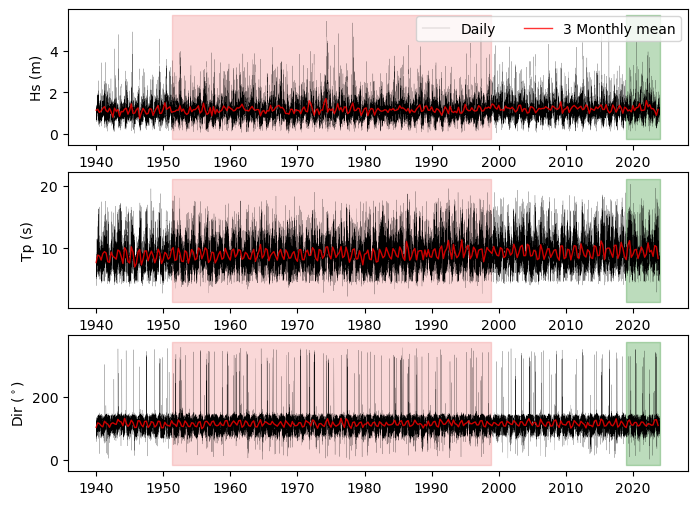

In [18]:
# Plot timeseries wave parameters averaged over transects
tran_id = 'Transect1'
labels = ['Hs (m)', 'Tp (s)', 'Dir ($^\circ$)']

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

for i, wave_param in enumerate(WAVE_PARAMS):
    # Calculate the average 
    df_mean = dfs_wave[wave_param].mean(1)
    print('{}:{}'.format(wave_param, df_mean.mean()))
    ax = axes[i]
    ax.plot(df_mean.index, df_mean.values, color='k', linewidth=0.1, label='Daily')
    ax.plot(df_mean.resample('3MS').mean().index, df_mean.resample('3MS').mean().values, color='r', linewidth=1, alpha=0.8,
           label='3 Monthly mean')
    ylim_up, ylim_down = ax.get_ylim()
    ax.fill_between(df_targ_medium.index, ylim_down, ylim_up, alpha=0.3, 
                    color='lightcoral')
    ax.fill_between(df_targ_short.index, ylim_down, ylim_up, alpha=0.3, 
                    color='forestgreen')
    ax.set_ylabel(labels[i])
    if i == 0:
        ax.legend(ncol=4)
plt.savefig('figures/wave_ts.jpg', dpi=300, bbox_inches='tight')    

# 1.4 Explore wave-shoreline correlations

In [19]:
def fallvelocity(D,Tw=15):
        

    """
    Calculates dimensionless fall velocity assuming T = 15 deg C
    Args:
        D: d50 in [m]
        g: Acceleration due to gravity
    Returns:
        dimensionless fall velocity in m/s
    """
    D=D*100
    ROWs=2.75 #Density of sand 
    g=981     #Gravity n cm**2/s
    
    T=np.array([5 ,10, 15, 20, 25])
    v   =np.array([0.0157, 0.0135, 0.0119, 0.0105, 0.0095])
    ROW =np.array([1.028, 1.027, 1.026, 1.025, 1.024])
    
    vw=np.interp(Tw,T,v)
    ROWw=np.interp(Tw,T,ROW)    
    
    A=((ROWs-ROWw)*g*(D**3))/(ROWw*(vw**2))
    
    if  A < 39:
        w= ((ROWs-ROWw)*g*(D**2))/(18*ROWw*vw)
    
    elif (A < 10**4):
        w = ((((ROWs-ROWw)*g/ROWw)**0.7)*(D**1.1))/(6*(vw**0.4))   
    else:
        w = np.sqrt(((ROWs-ROWw)*g*D)/(0.91*ROWw))
    w=w/100 #convert to SI (m/s)
    
    return w

In [20]:
N_months = np.arange(6, 120, 3)
N_days = (N_months*365/12.0).astype(int)
D50 = 0.3

df_Tp = pd.read_csv(os.path.join('datasets', 'hindcast_waves', 'Tp.csv'), parse_dates=['Datetime']).set_index('Datetime')
df_Hs = pd.read_csv(os.path.join('datasets', 'hindcast_waves', 'Hs.csv'), parse_dates=['Datetime']).set_index('Datetime')
w = fallvelocity(D50/1000)
df_omega = df_Hs/df_Tp/w
df_omega = df_omega.dropna()

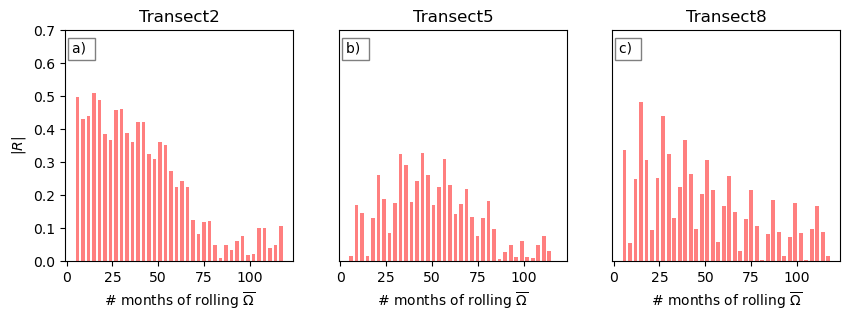

In [23]:
fig, axes = plt.subplots(1, len(target_trans), figsize=(10, 3))
letters = string.ascii_lowercase # Letters used to label subplots
best_window = {}
for i, tran_id in enumerate(target_trans):
    ax = axes[i]
    corrs = []
    for j, N_day in enumerate(N_days):
        roll_omega = df_omega[tran_id].rolling(N_day, center=False).mean()
        targ_index = roll_omega.index.intersection(df_obs[tran_id].dropna().index)
        targ_omega = roll_omega.loc[targ_index]
        targ_sl = df_obs.loc[targ_index, tran_id]
        corr = np.corrcoef(targ_omega, targ_sl)[0, 1]
        corrs.append(corr)
    best_window[tran_id] = N_days[np.argmax(np.abs(corrs))]
    ax.bar(N_months, np.abs(corrs), width=2, color='r', alpha=0.5)
    ax.set_xlabel('# months of rolling $\overline{\Omega}$')
    ax.set_ylim(0, 0.7)
    if i == 0:
        ax.set_ylabel('$|R|$')
    else:
        ax.set_yticks([])
    ax.set_title(tran_id)
    ax.text(0.03,0.95, letters[i] + ') ', 
            bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
            ha='left',va='top', transform=ax.transAxes, zorder=10)
#     xmin, xmax = ax.get_xlim()
#     ax.set(xlim=(xmin-0.25, xmax+0.25), axisbelow=True);
plt.savefig('figures/wave_shoreline_corrs1.jpg', dpi=300, bbox_inches='tight') 
        

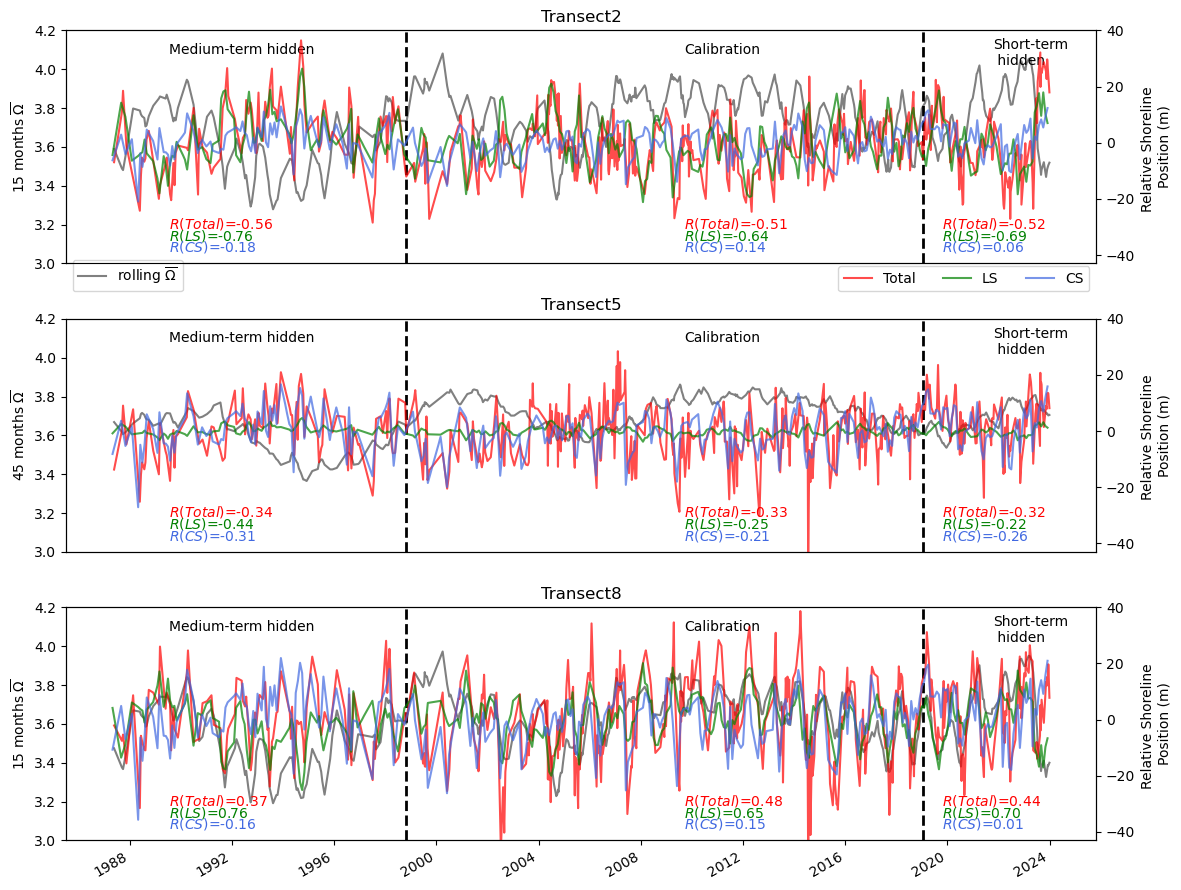

In [320]:
#fig, axes = plt.subplots(3, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [8, 2]})
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
for i, tran_id in enumerate(target_trans):
    ax = axes[i]
    N_day = best_window[tran_id]
    roll_omega = df_omega[tran_id].rolling(N_day).mean(center=False)
    targ_index = roll_omega.index.intersection(df_SDS[tran_id].dropna().index)
    targ_omega = roll_omega.loc[targ_index]
    targ_sl = df_SDS.loc[targ_index, tran_id] - df_SDS.loc[targ_index, tran_id].mean()
#     ax.bar(x=targ_index, height=roll_omega.loc[targ_index], width=pd.Timedelta(30, "D"), alpha=0.5, color='grey',
#            label='rolling $\overline{\Omega}$')
    roll_omega.loc[targ_index].plot(ax=ax, color='grey', label='rolling $\overline{\Omega}$')
    ax.set_ylim(3, 4.2)
    if i==0:
        ax.legend(loc=3, bbox_to_anchor=[0,-0.15])
    
    ax2 = ax.twinx()
    targ_sl.plot(ax=ax2, color='red', label='Total', alpha=0.7)
    ax2.plot(ls_df.index, ls_df[tran_id],
            label='LS', color='green', alpha=0.7)
    ax2.plot(cs_df.index, cs_df[tran_id],
            label='CS', color='royalblue', alpha=0.7)
    ax2.set_ylim(-43, 40)
    if i==0:
        ax2.legend(loc=4, ncol=3, bbox_to_anchor=[1,-0.15])
        
    if i!=2:
        ax.set_xticks([])
    ax.set_ylabel('{} months'.format(N_months[N_days==N_day][0])+' $\overline{\Omega}$')
    ax2.set_ylabel('Relative Shoreline \nPosition (m)')
    ax.set_xlabel('')
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Date format
    #ax.set_ylim(3.24, 4.2)
    ax.set_title(tran_id)
    
    ax.axvline(df_targ_medium.index[-1], 0, 1, color='k', linestyle='--', linewidth=2)
    ax.axvline(df_targ_short.index[0], 0, 1, color='k', linestyle='--', linewidth=2)
    

    ax.text(0.1, 0.9, 'Medium-term hidden', transform=ax.transAxes)
    ax.text(0.6, 0.9, 'Calibration', transform=ax.transAxes)
    ax.text(0.9, 0.85, 'Short-term\n hidden', transform=ax.transAxes)
    
    targ_index_mid = targ_index[targ_index<df_obs.index[0]]
    targ_index_cali = targ_index[(targ_index>=df_obs.index[0])&(targ_index<df_targ_short.index[0])]
    targ_index_short = targ_index[(targ_index>=df_obs.index[0])&(targ_index<=ls_df.index[-1])]
    
    corr_mid = np.corrcoef(targ_sl[targ_index_mid], roll_omega.loc[targ_index_mid])[0, 1]
    corr_cali = np.corrcoef(targ_sl[targ_index_cali], roll_omega.loc[targ_index_cali])[0, 1]
    corr_short = np.corrcoef(targ_sl[targ_index_short], roll_omega.loc[targ_index_short])[0, 1]
    
    ax.text(0.1,0.15, "$R (Total)$={:.2f}".format(corr_mid), transform=ax.transAxes, color='red')
    ax.text(0.6,0.15, "$R (Total)$={:.2f}".format(corr_cali), transform=ax.transAxes, color='red')
    ax.text(0.85,0.15, "$R (Total)$={:.2f}".format(corr_short), transform=ax.transAxes, color='red')

    corr_mid = np.corrcoef(roll_omega.loc[targ_index_mid], ls_df[tran_id].resample('D').interpolate().reindex(targ_index_mid))[0, 1]
    corr_cali = np.corrcoef(roll_omega.loc[targ_index_cali], ls_df[tran_id].resample('D').interpolate().reindex(targ_index_cali))[0, 1]
    corr_short = np.corrcoef(roll_omega.loc[targ_index_short], ls_df[tran_id].resample('D').interpolate().reindex(targ_index_short))[0, 1]

    ax.text(0.1,0.1, "$R (LS)$={:.2f}".format(corr_mid), transform=ax.transAxes, color='green')
    ax.text(0.6,0.1, "$R (LS)$={:.2f}".format(corr_cali), transform=ax.transAxes, color='green')
    ax.text(0.85,0.1, "$R (LS)$={:.2f}".format(corr_short), transform=ax.transAxes, color='green')

    corr_mid = np.corrcoef(roll_omega.loc[targ_index_mid], cs_df[tran_id].resample('D').interpolate().reindex(targ_index_mid))[0, 1]
    corr_cali = np.corrcoef(roll_omega.loc[targ_index_cali], cs_df[tran_id].resample('D').interpolate().reindex(targ_index_cali))[0, 1]
    corr_short = np.corrcoef(roll_omega.loc[targ_index_short], cs_df[tran_id].resample('D').interpolate().reindex(targ_index_short))[0, 1]

    ax.text(0.1,0.05, "$R (CS)$={:.2f}".format(corr_mid), transform=ax.transAxes, color='royalblue')
    ax.text(0.6,0.05, "$R (CS)$={:.2f}".format(corr_cali), transform=ax.transAxes, color='royalblue')
    ax.text(0.85,0.05, "$R (CS)$={:.2f}".format(corr_short), transform=ax.transAxes, color='royalblue')
    
#     ax3 = axes[i, 1]
#     metric_str = "$R$={:.2f}".format(np.corrcoef(targ_sl, roll_omega.loc[targ_index])[0, 1])
#     sns.kdeplot(x=targ_sl, y=roll_omega.loc[targ_index], fill=True, cmap='Reds',
#             ax=ax3)
#     ax3.text(0.1,0.2, metric_str, 
#         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
#         ha='left',va='top', transform=ax3.transAxes, zorder=10)
#     ax3.set_xlabel('Position')
#     ax3.set_ylabel('$\overline{\Omega}$')
    
fig.tight_layout()
plt.savefig('figures/wave_shoreline_corrs2.jpg', dpi=300, bbox_inches='tight') 

# 1.5 Check Sea level rise

In [22]:
# Read data

df_SLR_obs = pd.read_csv(
    os.path.join(fp, 'sealevel', 'sealevel_obs.csv'),
    index_col = 'Year')
df_SLR_proj = pd.read_csv(
    os.path.join(fp, 'sealevel', 'sealevel_proj.csv'),
    index_col = 'Year')

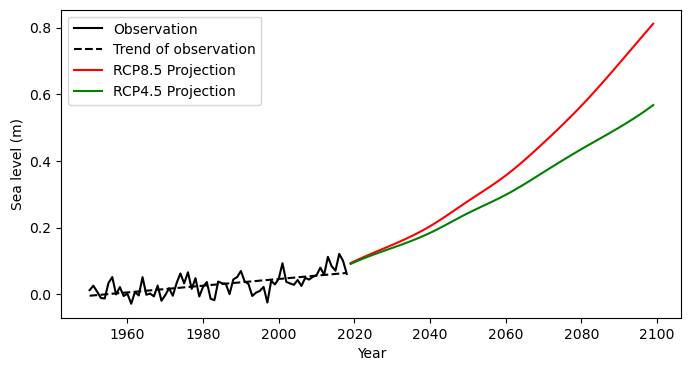

In [13]:
# Plot time series
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.hlines(df_SLR_obs['SLR (mm)'].mean(), df_SLR_obs.index[0], df_SLR_obs.index[-1], 
#           color='r', linestyle='--', label='baseline (Mean of observation)')
a, b = np.polyfit(df_SLR_obs.index, df_SLR_obs['Sealevel (m)'], 1)
ax.plot(df_SLR_obs.index, df_SLR_obs['Sealevel (m)'], color='k', linestyle='-', label='Observation')
ax.plot(df_SLR_obs.index, a*df_SLR_obs.index+b, color='k', linestyle='--', label='Trend of observation')
ax.plot(df_SLR_proj.index, df_SLR_proj['RCP85'], color='r', linestyle='-', label='RCP8.5 Projection')
ax.plot(df_SLR_proj.index, df_SLR_proj['RCP45'], color='g', linestyle='-', label='RCP4.5 Projection')

ax.set_xlabel('Year')
ax.set_ylabel('Sea level (m)')

plt.legend()
plt.savefig('figures/SLR_ts.jpg', dpi=300, bbox_inches='tight') 